In [1]:
'''
This code simply reads SST from HadISST and TS from Amon of CNL and the experiment runs
The purpose is to generate a simple ENSO-related plot. But no comparison at this stage.
All will then convert to suitable for pipeline with ESMValTools

History: Generate by Arnold and Lynn

'''

import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

# EOF
import sacpy as scp
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import sacpy.Map as smap
from scipy.linalg import svd



import os
os.getcwd()

%cd /g/data/p66/ars599/work_pmm

/g/data/p66/ars599/work_pmm


In [2]:
def plot_eof2(ssta,ttl,fName,xlon,xlat):
    '''
    # Example usage:
    # Assuming you have a variable 'ssta'
    ssta = n3_anom1.ts
    plot_eof(ssta)
    pcs_amo = plot_eof2(AMO,ttl,fName,310,40)
    '''
    eof = scp.EOF(np.array(ssta))
    eof.solve()
    pc = eof.get_pc(npt=2)
    pt = eof.get_pt(npt=2)

    lon, lat = np.array(ssta.lon), np.array(ssta.lat)

    # Check and ensure positive pt at 90W 0N
    lon_index = np.abs(lon - xlon).argmin()  # Find the index for 120W
    lat_index = np.abs(lat - xlat).argmin()    # Find the index for 0N

    if pt[0, lat_index, lon_index] < 0:
        pt[0] *= -1
        pc[0] *= -1
    if pt[1, lat_index, lon_index] < 0:
        pt[1] *= -1
        pc[1] *= -1

    fig = plt.figure(figsize=[12, 7])
    ax = fig.add_subplot(221)
    m1 = ax.contourf(lon, lat, pt[0, :, :], cmap=shayne_cmap, levels=np.linspace(-0.75, 0.75, 15), extend="both")
    ax.contour(m1, colors="black")
    ax.set_title(ttl[0])
    ax2 = fig.add_subplot(222)
#    ax2.plot(ssta.time, pc[0])
    ax2.plot(pc[0])
    ax2.grid()
    ax2.set_title(ttl[1])
    ax3 = fig.add_subplot(223) #, projection=ccrs.PlateCarree(central_longitude=180))
    m2 = ax3.contourf(lon, lat, pt[1, :, :], cmap=shayne_cmap, levels=np.linspace(-0.75, 0.75, 15), extend="both")
    ax3.contour(m2, colors="black")
    ax3.set_title(ttl[2])
    ax4 = fig.add_subplot(224)
#    ax4.plot(ssta.time, pc[1])
    ax4.plot(pc[1])
    ax4.grid()
    ax4.set_title(ttl[3])

    cb_ax = fig.add_axes([0.1, 0.06, 0.4, 0.02])
    fig.colorbar(m1, cax=cb_ax, orientation="horizontal")

    plt.savefig(fName+".png",dpi=300)
    plt.show()

    # Return the PCs as a tuple
    return pc

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def calculate_n3_anom(var, ystart, ylast):
    ystart_str = str(ystart).zfill(4)
    ylast_str = str(ylast).zfill(4)
    var = var.sel(time=slice(ystart_str, ylast_str))
    var_clim = var.groupby("time.month").mean(dim="time")
    var_anom = var.groupby("time.month") - var_clim
    return var_anom, var_clim


def quick_contour(fig, ax, T1, mag_max):
    '''
    fig, axs = plt.subplots(2, 2, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

    # Assuming T1 is a 2D array, you need to choose the appropriate subplot
    ax1 = axs[0, 0]  # Adjust this based on your requirements
    ax1, cbar1 = quick_contour(fig, ax, T1, mag_max)

    '''
    x = T1.lon - 180
    y = T1.lat
    
    # Plot T1 as a pcolormesh plot
    pcm = ax.pcolormesh(x, y, T1, vmax=mag_max, vmin=-1 * mag_max, cmap=shayne_cmap)
    
    # Add coastlines
    ax.coastlines(color='gray', linewidth=3)
    
    # Set latitude and longitude ticks
    ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    
    # Set tick label font size
    ax.tick_params(axis='both', labelsize=12)
    
    # Add colorbar
    cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.1)
    cbar.set_label('T1 Colorbar Label')  # Change the label as needed
    return ax, cbar


from matplotlib.colors import LinearSegmentedColormap
# Define the colors for the colormap
colors = [
    (0.0000000e+00, 0.0000000e+00, 1.0000000e+00),
    (1.0000000e-01, 1.0000000e-01, 1.0000000e+00),
    (2.0000000e-01, 2.0000000e-01, 1.0000000e+00),
    (3.0000000e-01, 3.0000000e-01, 1.0000000e+00),
    (4.0000000e-01, 4.0000000e-01, 1.0000000e+00),
    (5.0000000e-01, 5.0000000e-01, 1.0000000e+00),
    (6.0000000e-01, 6.0000000e-01, 1.0000000e+00),
    (7.0000000e-01, 7.0000000e-01, 1.0000000e+00),
    (8.0000000e-01, 8.0000000e-01, 1.0000000e+00),
    (9.0000000e-01, 9.0000000e-01, 1.0000000e+00),
    (1.0000000e+00, 1.0000000e+00, 1.0000000e+00),
    (1.0000000e+00, 9.0000000e-01, 9.0000000e-01),
    (1.0000000e+00, 8.0000000e-01, 8.0000000e-01),
    (1.0000000e+00, 7.0000000e-01, 7.0000000e-01),
    (1.0000000e+00, 6.0000000e-01, 6.0000000e-01),
    (1.0000000e+00, 5.0000000e-01, 5.0000000e-01),
    (1.0000000e+00, 4.0000000e-01, 4.0000000e-01),
    (1.0000000e+00, 3.0000000e-01, 3.0000000e-01),
    (1.0000000e+00, 2.0000000e-01, 2.0000000e-01),
    (1.0000000e+00, 1.0000000e-01, 1.0000000e-01),
    (1.0000000e+00, 0.0000000e+00, 0.0000000e+00)
]

# Create the colormap
shayne_cmap = LinearSegmentedColormap.from_list("shayne_cmap", colors)





# Data preparation

In [3]:

# Define input file paths
# Obs1 data
idir = "/g/data/p66/ars599/CMIP6/APP_output/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/"
ifiles = [ "/g/data/ct11/access-nri/replicas/esmvaltool/obsdata-v2/Tier2/HadISST/OBS_HadISST_reanaly_1_Amon_ts_187001-202112.nc",
    idir+"r4i1p1f1/Amon/ts/gn/v20240121/ts_Amon_ACCESS-CM2_piControl_r4i1p1f1_gn_106101-107912.nc",
    idir+"r4i1p1f4/Amon/ts/gn/v20240124/ts_Amon_ACCESS-CM2_piControl_r4i1p1f4_gn_106101-107912.nc"
]

ds_n34_tfile = [xr.open_dataset(os.path.join(idir, file)) for file in ifiles]


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [6]:
ts_obs_anm, ts_obs_clm = calculate_n3_anom(ds_n34_tfile[0].ts.sel(lat=slice(-20,20),lon=slice(120,280)),1980,2000) # make sure the variable name in HadISST is ts, sometimes it is sst.
ts_cnl_anm, ts_cnl_clm = calculate_n3_anom(ds_n34_tfile[1].ts.sel(lat=slice(-20,20),lon=slice(120,280)),1061,1080) # make sure the variable name in HadISST is ts, sometimes it is sst.
ts_exp_anm, ts_exp_clm = calculate_n3_anom(ds_n34_tfile[2].ts.sel(lat=slice(-20,20),lon=slice(120,280)),1061,1080) # make sure the variable name in HadISST is ts, sometimes it is sst.s


# EOF Analysis

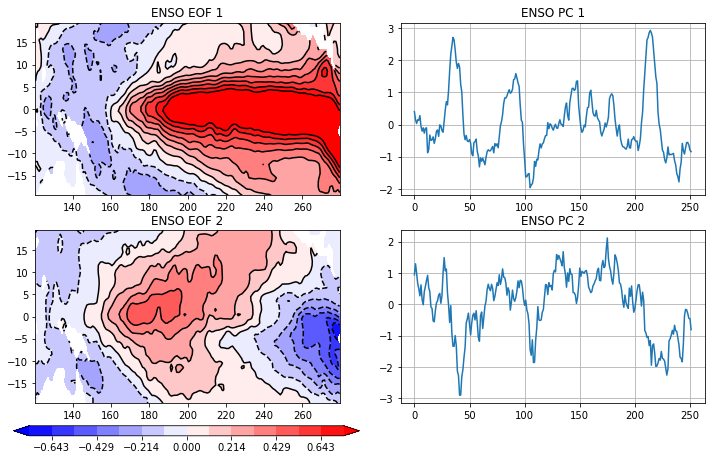

In [133]:
#ts_obs_anm.sel(lat=0,lon=180,method="nearest").plot()
'''
Only for ENSO
'''
ttl = ('ENSO EOF 1','ENSO PC 1','ENSO EOF 2','ENSO PC 2')
fName = "enso_anom_eof"
pcs_enso = plot_eof2(ts_obs_anm,ttl,fName,210,0)
plt.savefig('HadISST_ENSO_PC1_and_PC2.png', dpi=300)


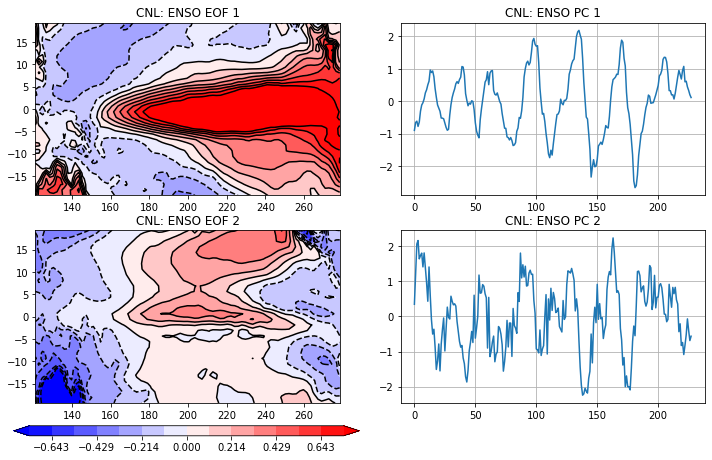

In [134]:
#ts_obs_anm.sel(lat=0,lon=180,method="nearest").plot()
'''
Only for ENSO
'''
ttl = ('CNL: ENSO EOF 1','CNL: ENSO PC 1','CNL: ENSO EOF 2','CNL: ENSO PC 2')
fName = "enso_cnl_anom_eof"
pcs_enso = plot_eof2(ts_cnl_anm,ttl,fName,210,0)
plt.savefig('CNL_ENSO_PC1_and_PC2.png', dpi=300)


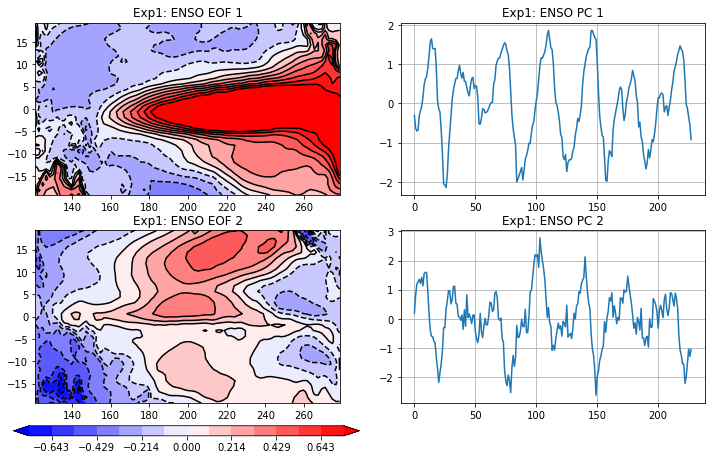

In [135]:
#ts_obs_anm.sel(lat=0,lon=180,method="nearest").plot()
'''
Only for ENSO
'''
ttl = ('Exp1: ENSO EOF 1','Exp1: ENSO PC 1','Exp1: ENSO EOF 2','Exp1: ENSO PC 2')
fName = "enso_exp_anom_eof"
pcs_enso = plot_eof2(ts_exp_anm,ttl,fName,210,0)
plt.savefig('EXP_ENSO_PC1_and_PC2.png', dpi=300)


# ENSO regression and correlation maps

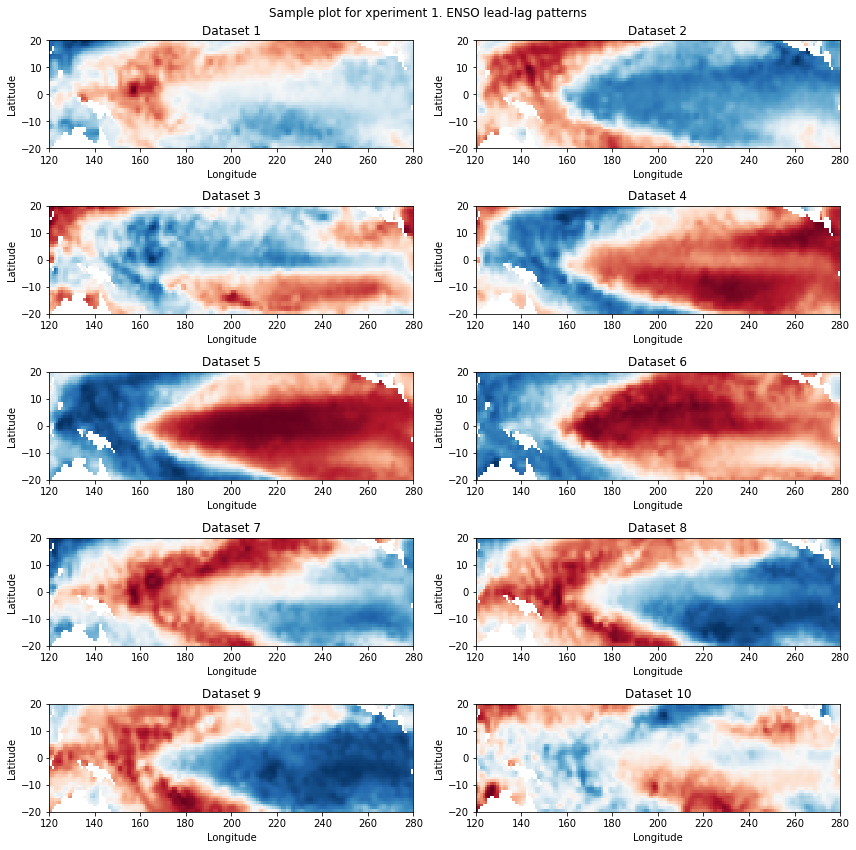

In [136]:
# -- Calculate nino3.4 index
nino = ts_obs_anm.sel(lon=slice(190,240),lat=slice(-5,5)).mean(["lat","lon"])
ninoSD=nino/nino.std(dim='time')
rninoSD=ninoSD.rolling(time=7, center=True).mean('time')

# -- Running mean
ranm = ts_obs_anm.rolling(time=7, center=True).mean('time')
rdanm = detrend_dim(ranm,'time',1)


# -- Correlation & Regression
# Leading
corM36 = xr.corr(rninoSD, rdanm.shift(time=-36), dim="time")
regM36 = xr.cov( rninoSD, rdanm.shift(time=-36), dim="time")/rninoSD.var(dim='time',skipna=True).values
corM24 = xr.corr(rninoSD, rdanm.shift(time=-24), dim="time")
regM24 = xr.cov( rninoSD, rdanm.shift(time=-24), dim="time")/rninoSD.var(dim='time',skipna=True).values
corM12 = xr.corr(rninoSD, rdanm.shift(time=-12), dim="time")
regM12 = xr.cov( rninoSD, rdanm.shift(time=-12), dim="time")/rninoSD.var(dim='time',skipna=True).values
corM6 = xr.corr(rninoSD, rdanm.shift(time=-6), dim="time")
regM6 = xr.cov( rninoSD, rdanm.shift(time=-6), dim="time")/rninoSD.var(dim='time',skipna=True).values

# simultaneous
cor0 = xr.corr(rninoSD, rdanm, dim="time")
reg0 = xr.cov(rninoSD, rdanm, dim="time")/rninoSD.var(dim='time',skipna=True).values

# Laging
corP6 = xr.corr(rninoSD, rdanm.shift(time=6), dim="time")
regP6 = xr.cov( rninoSD, rdanm.shift(time=6), dim="time")/rninoSD.var(dim='time',skipna=True).values
corP12 = xr.corr(rninoSD, rdanm.shift(time=12), dim="time")
regP12 = xr.cov( rninoSD, rdanm.shift(time=12), dim="time")/rninoSD.var(dim='time',skipna=True).values
corP18 = xr.corr(rninoSD, rdanm.shift(time=18), dim="time")
regP18 = xr.cov( rninoSD, rdanm.shift(time=18), dim="time")/rninoSD.var(dim='time',skipna=True).values
corP24 = xr.corr(rninoSD, rdanm.shift(time=24), dim="time")
regP24 = xr.cov( rninoSD, rdanm.shift(time=24), dim="time")/rninoSD.var(dim='time',skipna=True).values
corP36 = xr.corr(rninoSD, rdanm.shift(time=36), dim="time")
regP36 = xr.cov( rninoSD, rdanm.shift(time=36), dim="time")/rninoSD.var(dim='time',skipna=True).values


cor_reg_lst = [corM36,corM24,corM12,corM6,cor0,corP6,corP12,corP18,corP24,corP36 ]

# Reshaping the datasets for 5x2 subplot arrangement
num_rows, num_cols = 5, 2

lat = ts_obs_anm.lat
lon = ts_obs_anm.lon

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))  # Adjust the figsize as needed
fig.suptitle('Sample plot for xperiment 1. ENSO lead-lag patterns')

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        if index < len(cor_reg_lst):
            ax = axs[i, j]
            ax.pcolormesh(lon,lat,cor_reg_lst[index])  # Plot contour for cor_lst
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.set_title(f'Dataset {index + 1}')

plt.tight_layout()
plt.savefig('enso_sample1_.png', dpi=300)
plt.show()


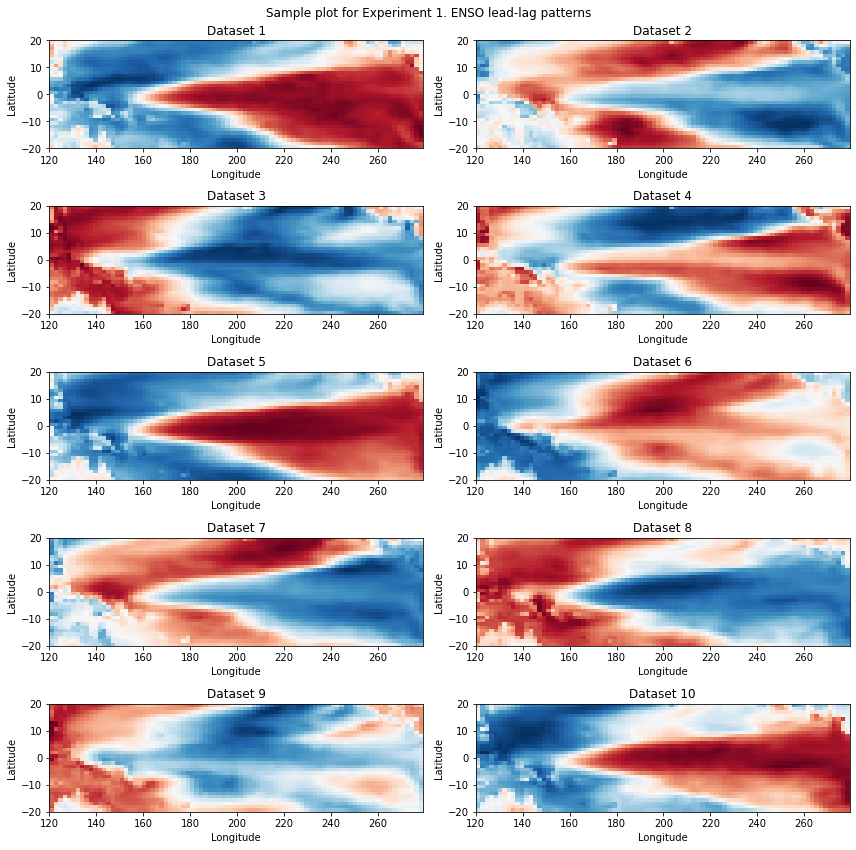

In [140]:
# -- Calculate nino3.4 index
nino = ts_exp_anm.sel(lon=slice(190,240),lat=slice(-5,5)).mean(["lat","lon"])
ninoSD=nino/nino.std(dim='time')
rninoSD=ninoSD.rolling(time=3, center=True).mean('time')

# -- Running mean
ranm = ts_exp_anm.rolling(time=3, center=True).mean('time')
rdanm = detrend_dim(ranm,'time',1)

# -- Running mean
lat = ts_exp_anm.lat
lon = ts_exp_anm.lon


# -- Correlation & Regression
# Leading
corM36 = xr.corr(rninoSD, rdanm.shift(time=-36), dim="time")
regM36 = xr.cov( rninoSD, rdanm.shift(time=-36), dim="time")/rninoSD.var(dim='time',skipna=True).values
corM24 = xr.corr(rninoSD, rdanm.shift(time=-24), dim="time")
regM24 = xr.cov( rninoSD, rdanm.shift(time=-24), dim="time")/rninoSD.var(dim='time',skipna=True).values
corM12 = xr.corr(rninoSD, rdanm.shift(time=-12), dim="time")
regM12 = xr.cov( rninoSD, rdanm.shift(time=-12), dim="time")/rninoSD.var(dim='time',skipna=True).values
corM6 = xr.corr(rninoSD, rdanm.shift(time=-6), dim="time")
regM6 = xr.cov( rninoSD, rdanm.shift(time=-6), dim="time")/rninoSD.var(dim='time',skipna=True).values

# simultaneous
cor0 = xr.corr(rninoSD, ts_exp_anm, dim="time")
reg0 = xr.cov(rninoSD, rdanm, dim="time")/rninoSD.var(dim='time',skipna=True).values

# Laging
corP6 = xr.corr(rninoSD, rdanm.shift(time=6), dim="time")
regP6 = xr.cov( rninoSD, rdanm.shift(time=6), dim="time")/rninoSD.var(dim='time',skipna=True).values
corP12 = xr.corr(rninoSD, rdanm.shift(time=12), dim="time")
regP12 = xr.cov( rninoSD, rdanm.shift(time=12), dim="time")/rninoSD.var(dim='time',skipna=True).values
corP18 = xr.corr(rninoSD, rdanm.shift(time=18), dim="time")
regP18 = xr.cov( rninoSD, rdanm.shift(time=18), dim="time")/rninoSD.var(dim='time',skipna=True).values
corP24 = xr.corr(rninoSD, rdanm.shift(time=24), dim="time")
regP24 = xr.cov( rninoSD, rdanm.shift(time=24), dim="time")/rninoSD.var(dim='time',skipna=True).values
corP36 = xr.corr(rninoSD, rdanm.shift(time=36), dim="time")
regP36 = xr.cov( rninoSD, rdanm.shift(time=36), dim="time")/rninoSD.var(dim='time',skipna=True).values


cor_reg_lst = [corM36,corM24,corM12,corM6,cor0,corP6,corP12,corP18,corP24,corP36 ]

# Reshaping the datasets for 5x2 subplot arrangement
num_rows, num_cols = 5, 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))  # Adjust the figsize as needed
fig.suptitle('Sample plot for Experiment 1. ENSO lead-lag patterns')

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        if index < len(cor_reg_lst):
            ax = axs[i, j]
            ax.pcolormesh(lon,lat,cor_reg_lst[index])  # Plot contour for cor_lst
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.set_title(f'Dataset {index + 1}')

plt.tight_layout()
plt.savefig('enso_sample2_.png', dpi=300)
plt.show()


# Spectrum analysis

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 252, using nperseg = 252
  warnings.warn('nperseg = {0:d} is greater than input length '


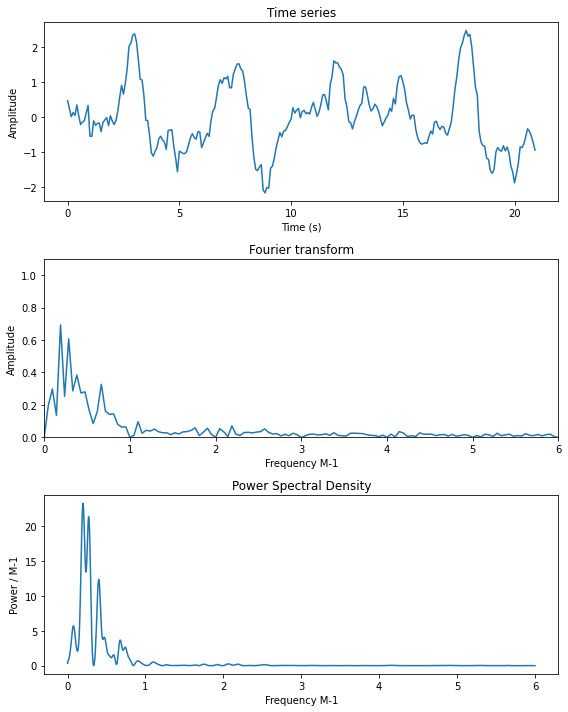

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Length of time series in seconds
T = 1

# Sample frequency
Fs = 12

# Sample length
dt = 1 / Fs

# Number of time samples
N = len(nino); # int(T / dt)

# Time vector
t = np.arange(N) * dt

# Frequency vector
f = np.arange(N // 2 + 1) * Fs / N

# Frequency content of the signal (three frequencies in Hz)
F1 = 200
F2 = 400
F3 = 350
sigma = 3  # Standard deviation of the noise to be added

# Create time series
r = nino

# Compute one-sided FFT
R = np.fft.fft(r)
R2 = np.abs(R / N)
R1 = R2[: N // 2 + 1] * 2

# Compute power spectral density (autospectrum)
fxx, pxx = welch(r, fs=Fs, window="bartlett", nperseg=256, noverlap=128, nfft=2048)

# Plot results
plt.figure(figsize=(8, 10))

plt.subplot(3, 1, 1)
plt.plot(t, r, "-")
plt.title("Time series")
plt.xlabel("Time (Mon)")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 2)
plt.plot(f, R1, "-")
plt.title("Fourier transform")
plt.xlabel("Frequency M-1")
plt.ylabel("Amplitude")
plt.axis([0, Fs / 2, 0, 1.1])

plt.subplot(3, 1, 3)
plt.plot(fxx, 2 * np.pi * pxx)
plt.title("Power Spectral Density")
plt.xlabel("Frequency M-1")
plt.ylabel("Power / M-1")

plt.tight_layout()
plt.savefig('enso_sample3_.png', dpi=300)
plt.show()
